# 【第1回目　課題１】PyTorchを用いた深層学習 (1): 全結合編

第1回目の課題１では，最も簡単な深層学習フレームワークと言われている<a href="https://pytorch.org/">PyTorch</a>を用いて，取り組んでみましょう．

まずは，<a href="https://pytorch.org/tutorials/">PyTorchの公式チュートリアル</a>を見てみましょう．

PyTorchには，<a href="https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html">Sequential model</a> と 
<a href="https://keras.io/ja/getting-started/functional-api-guide/">nn.Moduleを継承する</a>，２つの書き方があります．

レイヤーを単純につなげていくだけの簡単なモデルの場合は，Sequential model で十分ですので，今回はSequential model を使うことにします．

課題としては，前回同様に
全結合層＋ReLU＋2乗誤差関数 のネットワークを考えてみます．
全結合層を使って任意の関数の近似を行います．

最初に Pytorch の実行に必要な モジュールを import します．

In [669]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from math import *

まず，近似する関数の定義を行って，学習データ(training data)，検証データ(validation data)を生成します．データの定義は，基本的に前回と同じですが，学習で使うデータは，<a href="https://pytorch.org/docs/stable/tensors.html">torch.Tensor型</a>にしておく必要があります．ここでは，nupmyから変換する <a href="https://pytorch.org/docs/stable/torch.html#torch.from_numpy">from_numpy関数</a>を利用しています．

In [670]:
def f(x):
#    return 0.5*(x-3)**2-5
#    return 5*(x-2)**3-10*x**2-8*x-1
#    return 1/(20-x**2)
    return (5*np.sin(x) + 5*(np.sin(3*x) + np.sin((4*x))))

X_train0=np.arange(-10,10,0.01,dtype=np.float32)
Y_train0= f(X_train0)
# X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
X_train=torch.from_numpy(np.reshape(X_train0,[-1,1])) # , requires_grad=True)   # (2000,)  -> (2000,1)
Y_train=torch.from_numpy(np.reshape(Y_train0,[-1,1])) 
num_train=np.size(X_train0)

# テスト用の x も準備します．
X_val0=np.arange(-8,8,0.1,dtype=np.float32)
Y_val0= f(X_val0)
X_val=torch.from_numpy(np.reshape(X_val0,[-1,1]))
Y_val=torch.from_numpy(np.reshape(Y_val0,[-1,1]))
num_val=np.size(X_val0)

次に学習中にグラフを表示するための ShowGraph classを定義しておきます．(Kerasはこれをコールバック関数として指定しますが，PyTorchではユーザが呼び出します．）

In [671]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 50])
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2.set_title('y=0.5(x-2)^2-5')
        self.fig2.set_ylabel('f(x)')
        self.fig2.set_xlabel('x')
        self.model=model
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, val_loss):
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.losses_val.append(val_loss)     
        self.loss_val=val_loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"b")
        self.fig1.plot(self.n_epoch,self.losses_val,"r")
        with torch.no_grad():   # backwardは計算しないので，計算途中の値を記録しないようにする．
            Y_pred=self.model(X_val)
        x0=np.reshape(X_val0,[-1])
        y0=torch.reshape(Y_pred,[-1]).detach().cpu().numpy()
        self.fig2.plot(x0,y0,"b")
        self.fig2.plot(x0,f(x0),"r")
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()
    
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss_val:",self.loss_val) 
        print('Time: ',time.time()-self.start)

さあ，いよいよモデルを定義します．
前回と違って，当然ですが，全結合層クラスはPyTorchに含まれているので，実装は不要です．
PyTorchでは，nn.Linear が fcに相当します．
```python
  nn.Linear(1,20)
```

次に学習するネットワークを記述してみましょう．
前回は以下のように1x20+ReLU +20x20+ReLU + 20x1 の３層となっていました．
```python
fc1=Fc(1,20)
fc2=Fc(20,20)
fc3=Fc(20,1,False)
```
Sequential モデルでは，nn.Sequential の引数の中に，連続するレイヤーを記述します．
nn.Linear が全結合，nn.ReLuがReLU関数です．

In [672]:
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
)

In [673]:
import torch.nn as nn
import torch.nn.functional as F
# nn.Moduleを継承する書き方
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(1, 20)
        self.linear_2 = nn.Linear(20, 20)
        self.linear_3 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.linear_3(x)
        return x

# このパターンもいける
class Model_Sequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
        )
    def forward(self, x):
        x = self.sequential_model(x)
        return x

# model = Model()

### モデルで使える関数　　


#### register_buffer
model.parametersでは出てこない(最適化パラメータではない)のに、model.state_dictでは出てくる（保存が可能）という点で、非常に使い勝手がいい。

In [674]:
class A(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(10))#更新される
        self.register_buffer('b', torch.randn(10))# 更新されない

    def forward(self, x):
        return self.a*x + self.b


#### model.apply  
Pytorchのmodel. apply()関数はモデルの中にある全てのモジュールを再帰的に掘って関数を適用できる。
    - 初期化について　https://pystyle.info/pytorch-parameters-initialization/

In [675]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        print(m,"の重みを初期化しました")
#         nn.init.xavier_uniform_(m.weight)　#

model = Model()
model.apply(weights_init)

Linear(in_features=1, out_features=20, bias=True) の重みを初期化しました
Linear(in_features=20, out_features=20, bias=True) の重みを初期化しました
Linear(in_features=20, out_features=1, bias=True) の重みを初期化しました


Model(
  (linear_1): Linear(in_features=1, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=20, bias=True)
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
)

#### model.parameters()の中身のみかた

In [676]:
model.parameters()

<generator object Module.parameters at 0x1531cb5f0>

リストにすると見れる  
上から順にweight,biasで今回だと計６つ

In [677]:
params = list(model.parameters())
len(params)

6

#### モデルの保存  torch.save(the_model.state_dict(), PATH)  
学習した後のモデルを保存するときに使う

In [678]:
#torch.save(model.state_dict(), './pretrained_model.pth')#保存　拡張子はpt か pth
#model.load_state_dict(torch.load("pretrained_model.pth"))#ロード

#### 使える関数の説明　終わり

モデルを表示するには，
```python
print(model)
```
とするだけでOKです．

In [679]:
print(model)

Model(
  (linear_1): Linear(in_features=1, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=20, bias=True)
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
)


次に，<a href="https://pytorch.org/docs/stable/nn.functional.html#loss-functions">損失関数(loss function)</a>と <a href="https://pytorch.org/docs/stable/optim.html">最適化手法(optimizer)</a> の準備を行います．

損失関数は，回帰問題なので，<a href="https://pytorch.org/docs/stable/nn.functional.html#mse-loss">最小２乗誤差(mean_squared_error)</a> を使います．最適化手法(optimizer)は，<a href="https://pytorch.org/docs/stable/optim.html?highlight=sgd#torch.optim.SGD">標準的な SGD</a>を使います．
なお，標準SDGとモーメンタムSDGの区別はありません．momentum rate の指定で区別できます．デフォルトでは，momentum rate=0.0 ですので，標準SDGになります．mometum=0.9 とすれば，一般的なモーメンタムSDGとなります．weight_decay は，Weight Decay という重みの正則化パラメータです．1e-6 など通常は小さい値を指定しますが，最初はweight_decayを使わないことにして 0 としておきます．

In [680]:
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.0, weight_decay=0.0)
#optimizer = optim.RMSprop(model.parameters(), lr=0.0040, momentum=0.0, weight_decay=0.0)
x = torch.tensor(-10.0)#, requires_grad=True)
y = torch.tensor(40.0)#, requires_grad=True)
#optimizer = optim.Adam([x, y], lr=0.01, betas=(0.09, 0.009))
optimizer = optim.Adam(model.parameters(), lr=0.01)

学習を始める前に，モデルとデータをGPUに転送しておきます．これをしないとGPUがあっても，CPU計算となってしまい，時間がかかってしまいます．
```python
model.to('cuda')
``` 
とします．実際には，GPUが使えるかをチェックして，GPUがあれば，変数deviceに'cuda'を，なければ'cpu'を入れて，model.to(device) とするのが一般的です．('gpu'ではなくて，NVIDIAのGPU演算ライブラリの名称 'cuda'を指定するので，注意が必要です．）

PyTorchでは，GPUを使う場合には明示的にGPUにデータやモデルを転送する必要があります．
学習モデルをsaveする場合には，CPUに一度GPUからモデルを戻してやる必要があります．
この様に，PyTorchでGPUを使う場合には，データやモデルが今，GPU/CPUのどちらにあるか
を常に意識する必要があります．

(なお，Kerasでは，GPUがあれば自動的にGPUにモデルやデータが転送されて，GPU上で計算が行われますので，ユーザは特にGPU/CPUの区別を気にする必要はありません．）

In [681]:
# GPU があれば，GPU にmodelを転送.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_val=X_val.to(device)
Y_val=Y_val.to(device)

なお，GPUが複数ある環境では，
```python
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
```
として，最初からPyTorchで利用可能なGPUを限定してしまう方法と，
```python
device='cuda:1' 
```
の様に cuda: の後にGPU ID (0から始まる)を記述する方法があります．

他に標準GPUのIDを指定する方法もあります．
```python
torch.cuda.set_device(3) 
```
とすると，これ以降, 'cuda' が 'cuda:3' と同じになります．

torch.cuda.device_count() を使うと利用可能なGPUを表示することができます．
最初の方法で環境変数で限定してしまうと指定したGPUの数が表示されますが，
他の方法ではシステムの全てのGPU数が表示されます．

詳しくは，<a href="https://pytorch.org/docs/stable/cuda.html">torch.cuda</a> のドキュメントを見ましょう．

In [682]:
import torch
torch.cuda.device_count()

0

いよいよ，学習です．

PyTorchでは，Kerasと違って自分で学習ループを書く必要があります．

epoch数 と batch_sizeを決めて，(epoch数)×ceil(学習データ数/batch_size)回だけ
ループを回してやる必要があります．(ceilは小数点以下切り上げ)

学習ループ内では，
1. 学習データの順伝搬
1. 誤差勾配の逆伝搬
1. SGDなどのoptimizerで，重みをupdate
の3つの処理が必要です．
このために，
```python
loss = loss_fn(Y_pred, Y_train)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```
とします．勾配は元の値に加算されるので，optimizer.zero_grad() として，必ず back-propagationの前にクリアしておきます．

さらに学習途中の様子を見るために，ここでは，5エポック毎に，
学習途中のモデルでテストデータを評価して，そのグラフ(つまり，学習途中の$y=f(x)$)を描画するとともに，training loss, test lossを両方グラフに表示します．

loss_val: 17.656982421875
Time:  138.45480227470398


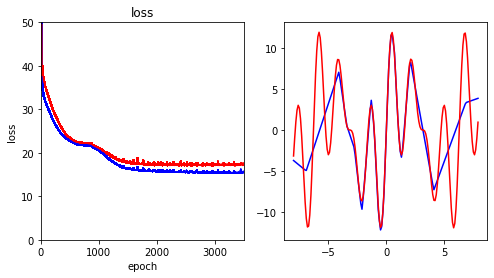

In [683]:
%%time
num_epoch=3500
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

### 課題1
以下の小問の(1)-(2)を解答せよ．
(再実行する場合は，モデル定義から下だけ実行すれば大丈夫です．）

1. OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．    
標準SGD  
損失関数の降下が遅く350epoch内で収束しない。つまり学習が遅い。
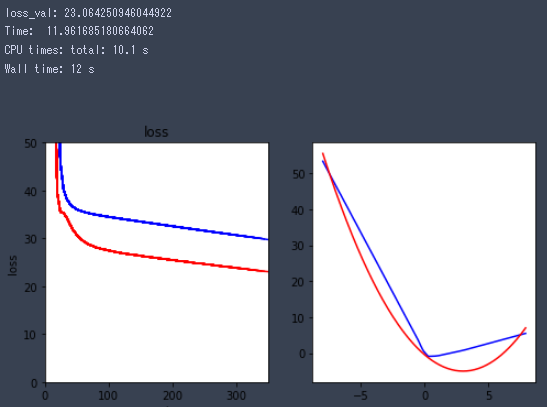  

モーメンタムSGD(momentum=0.9)  
標準SGDよりも学習が速い。学習の初期（低epoch)で損失関数が標準SGDよりも振動するのは慣性が少ないためかもしれないが、標準SGDよりも振動が激しい原因はよくわからない。
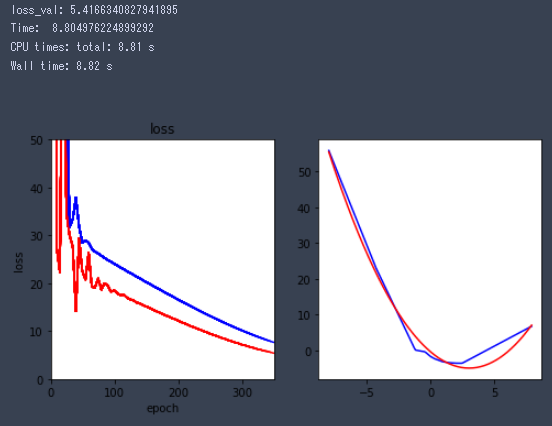

RMSprop  
損失関数の減少の仕方が低から高epoch全域で一定だった。
先に試したSGDと同じlr: 0.0001で実施すると失関数の降下が遅かったが、lr: 0.002にすると低epochでSDGよりも急降下するようになった。
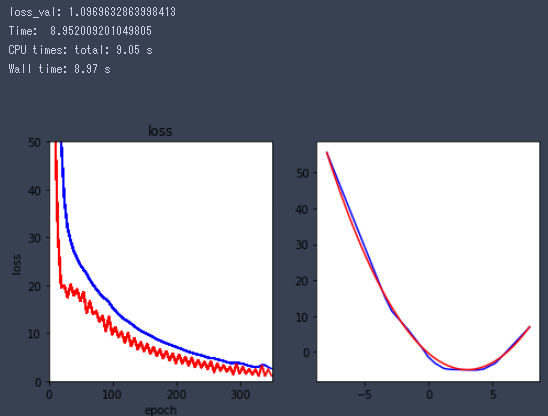

Adam (ダークモードの3090機での計算をやめてM1 Macbookで計算した）  
最も速く損失関数が降下し、学習後の曲線もオリジナルの関数に一番近い。つまり最も学習が速く精度も高い。まとめると学習速度は、SGD<MomentumSGD<RMSProp<Adamであった。
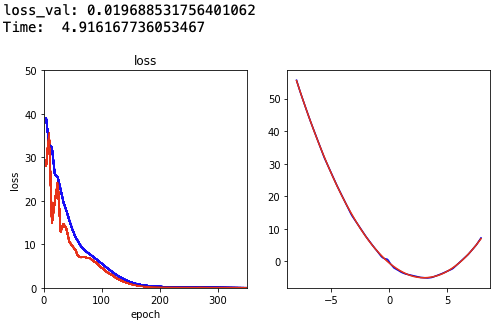

2. 関数 $f(x)$ を自由に書き換え，実行せよ．2通りの $f(x)$ で試してみよ．  
#### 一つ目の関数: $$f(x)=\frac{1}{20-x^2}$$
特異点近傍をどのように学習されるのか調べた。OptimiserはAdamとした。数回に１回片方の特異点を学習し、さらに低い頻度で両方の特異点を学習した。いずれの学習でepochを重ねてもごく低epochを除いて損失関数の降下はほとんど見られなかった。この関数の特異点を学習できるかどうかは学習モデルの初期パラメータに大きく依存しているためと考えられる。つまり勾配降下によるパラメータ収束ではこの関数に対するコストを最小にできないことを示している。
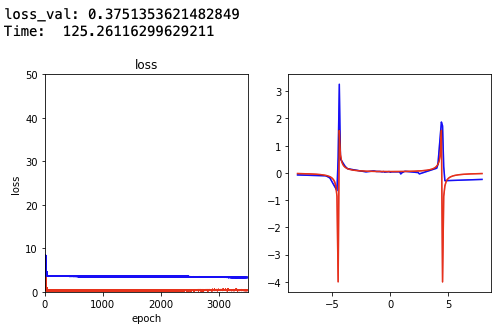  
#### 二つ目の関数: $$f(x)=\sin x + 5(\sin 3x + \sin 4x)$$
次に連続な関数でピークが連続するようなものについて実施した。OptimiserはAdamとした。最初の不連続な関数と違ってエポック数を経るにつれて損失関数が減少する。低epochで原点近傍を中心として原点について点対象に原点に近いピークから学習が進む。ただ、ばらつきはepoch数にばらつきはあるもののある3個目のピークを過ぎたあたりから損失関数が降下しなくなる。これはピーク（局所解）が多数ある場合に学習が進まなくなることを示している。確実にフーリエ解析が最適で、このことから目的関数がどのような形なのか少しでもわかれば、NNかそれ以外か、あるいはNNでどのような工夫ができるか等、より良い手法を選択できることも示唆している。
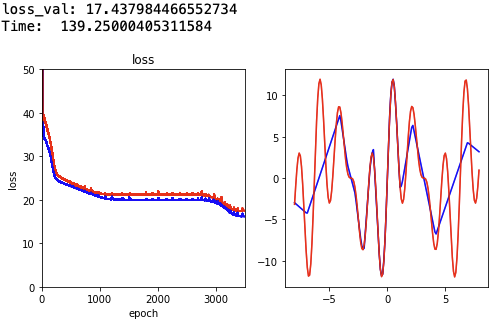


参考URL:フーリエ解析 https://yagami12.hatenablog.com/entry/2018/10/03/132418